In [1]:
# Import necessary libraries and set the computation device
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [2]:
# Custom dataset that performs face detection and cropping
class FaceCroppedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = image[y:y+h, x:x+w]
        else:
            face = image  # fallback if no face detected

        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)

        if self.transform:
            face = self.transform(face)

        return face, label

# Create data loaders with face detection + augmentation
def get_dataloaders(data_dir, image_size=(224, 224), batch_size=32):
    # Data augmentation for training set
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.RandomResizedCrop(image_size[0], scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Transform for test set
    test_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load datasets using FaceCroppedDataset
    train_dataset = FaceCroppedDataset(os.path.join(data_dir, "train"), transform=train_transform)
    test_dataset = FaceCroppedDataset(os.path.join(data_dir, "test"), transform=test_transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset.dataset.classes, test_transform


In [3]:
# Initialize a ResNet18 model with a custom classification head
def initialize_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model.to(device)


In [4]:
# Train and evaluate the model for a number of epochs
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []

    # Loop through each epoch
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        # Loop through training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(running_loss / len(train_loader))

        # Evaluation phase
        model.eval()
        correct, total, test_loss = 0, 0, 0.0
        with torch.no_grad():
            # Loop through test data
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list


In [5]:
# Evaluate the model on the test set and display metrics
def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    # Loop through test data to collect predictions
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Generate and display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Reds')
    plt.title("Confusion Matrix")
    plt.show()


In [6]:
# Plot training and test accuracy and loss over epochs
def plot_training_curves(train_acc, test_acc, train_loss, test_loss):
    plt.figure(figsize=(12, 5))

    # Plot accuracy curves
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    # Plot loss curves
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
# Detect faces in an image and predict emotions using the trained model
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

def predict_faces_in_image(image_path, model, transform, class_names):
    img = cv2.imread(image_path)
    original_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        print("No faces detected.")
        return

    model.eval()
    # Loop through detected faces and make predictions
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        input_tensor = transform(face_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, pred = torch.max(outputs, 1)
            label = class_names[pred.item()]

        cv2.rectangle(original_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(original_img, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show image with predictions
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.title("Detected Faces with Predicted Emotions")
    plt.show()


In [8]:
# Train and evaluate model on RAF-DB dataset
raf_train_loader, raf_test_loader, raf_classes, raf_transform = get_dataloaders("RAF-DB")
raf_model = initialize_model(len(raf_classes))
raf_optimizer = torch.optim.Adam(raf_model.parameters(), lr=0.001)
raf_criterion = nn.CrossEntropyLoss()

print("\nTraining on RAF-DB...\n")
raf_train_acc, raf_test_acc, raf_train_loss, raf_test_loss = train_and_evaluate(
    raf_model, raf_train_loader, raf_test_loader,
    raf_criterion, raf_optimizer, num_epochs=10
)

# Train and evaluate model on FER-2013 dataset
fer_train_loader, fer_test_loader, fer_classes, fer_transform = get_dataloaders("FER-2013")
fer_model = initialize_model(len(fer_classes))
fer_optimizer = torch.optim.Adam(fer_model.parameters(), lr=0.001)
fer_criterion = nn.CrossEntropyLoss()

print("\nTraining on FER-2013...\n")
fer_train_acc, fer_test_acc, fer_train_loss, fer_test_loss = train_and_evaluate(
    fer_model, fer_train_loader, fer_test_loader,
    fer_criterion, fer_optimizer, num_epochs=10
)



Training on RAF-DB...

Epoch [1/10] | Train Acc: 61.84% | Test Acc: 66.06%
Epoch [2/10] | Train Acc: 71.78% | Test Acc: 77.27%
Epoch [3/10] | Train Acc: 75.51% | Test Acc: 80.40%
Epoch [4/10] | Train Acc: 77.90% | Test Acc: 81.67%
Epoch [5/10] | Train Acc: 79.97% | Test Acc: 81.91%
Epoch [6/10] | Train Acc: 80.44% | Test Acc: 76.38%
Epoch [7/10] | Train Acc: 81.97% | Test Acc: 79.26%
Epoch [8/10] | Train Acc: 83.19% | Test Acc: 84.35%
Epoch [9/10] | Train Acc: 83.32% | Test Acc: 82.46%
Epoch [10/10] | Train Acc: 84.68% | Test Acc: 81.16%

Training on FER-2013...

Epoch [1/10] | Train Acc: 46.25% | Test Acc: 53.57%
Epoch [2/10] | Train Acc: 53.59% | Test Acc: 55.78%
Epoch [3/10] | Train Acc: 56.09% | Test Acc: 58.40%
Epoch [4/10] | Train Acc: 58.62% | Test Acc: 60.24%
Epoch [5/10] | Train Acc: 60.21% | Test Acc: 60.96%
Epoch [6/10] | Train Acc: 61.72% | Test Acc: 61.61%
Epoch [7/10] | Train Acc: 62.86% | Test Acc: 63.12%
Epoch [8/10] | Train Acc: 64.18% | Test Acc: 63.28%
Epoch [9/10] 


Evaluation on RAF-DB:

Classification Report:

              precision    recall  f1-score   support

       angry       0.77      0.76      0.77       162
        fear       0.79      0.35      0.49        74
       happy       0.95      0.88      0.91      1185
     nuetral       0.76      0.75      0.76       680
         sad       0.62      0.91      0.74       478
    surprise       0.90      0.70      0.78       329

    accuracy                           0.81      2908
   macro avg       0.80      0.72      0.74      2908
weighted avg       0.83      0.81      0.81      2908



<Figure size 800x600 with 0 Axes>

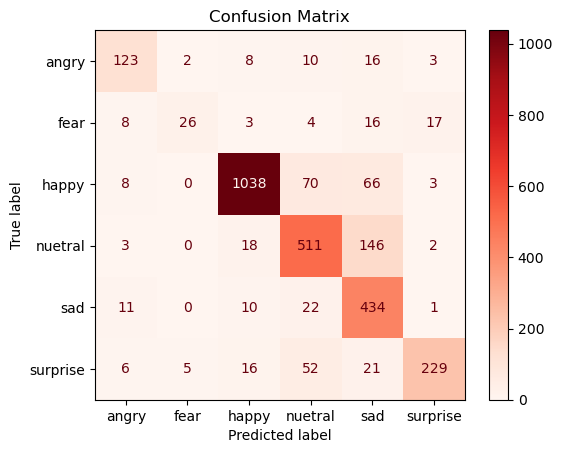

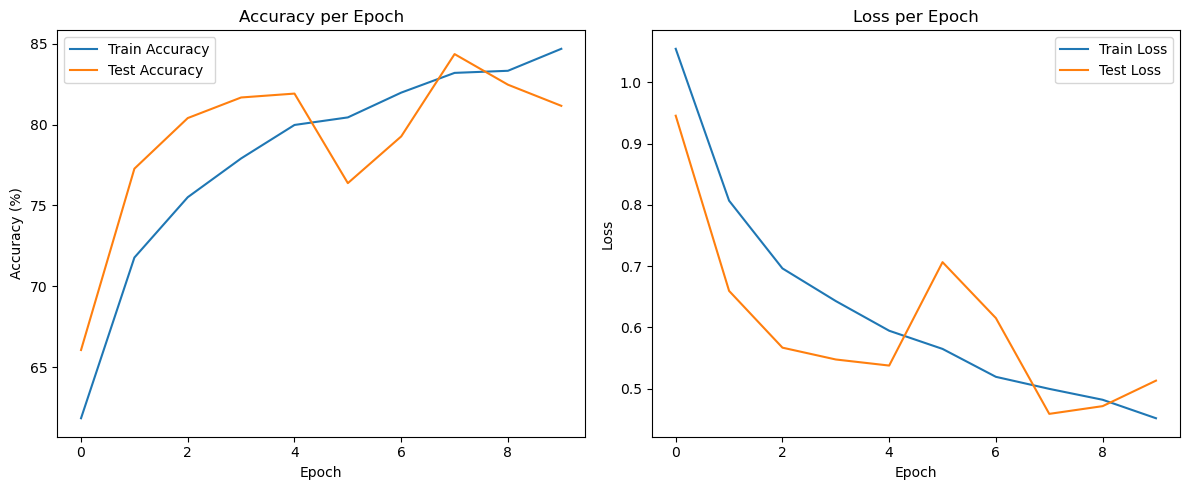


Evaluation on FER-2013:

Classification Report:

              precision    recall  f1-score   support

       angry       0.52      0.65      0.58       958
        fear       0.51      0.33      0.40      1024
       happy       0.84      0.88      0.86      1774
     neutral       0.56      0.69      0.62      1233
         sad       0.58      0.44      0.50      1247
    surprise       0.72      0.80      0.76       831

    accuracy                           0.65      7067
   macro avg       0.62      0.63      0.62      7067
weighted avg       0.64      0.65      0.64      7067



<Figure size 800x600 with 0 Axes>

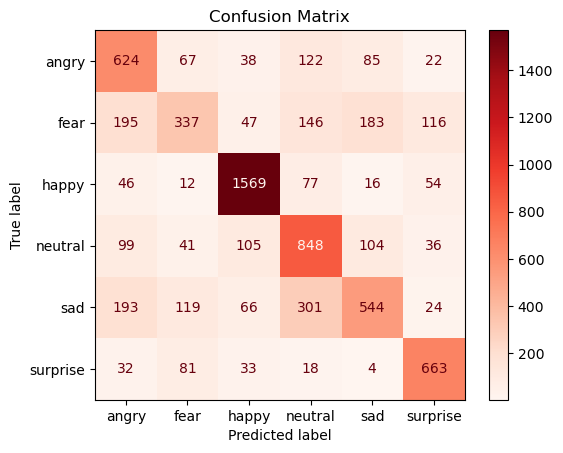

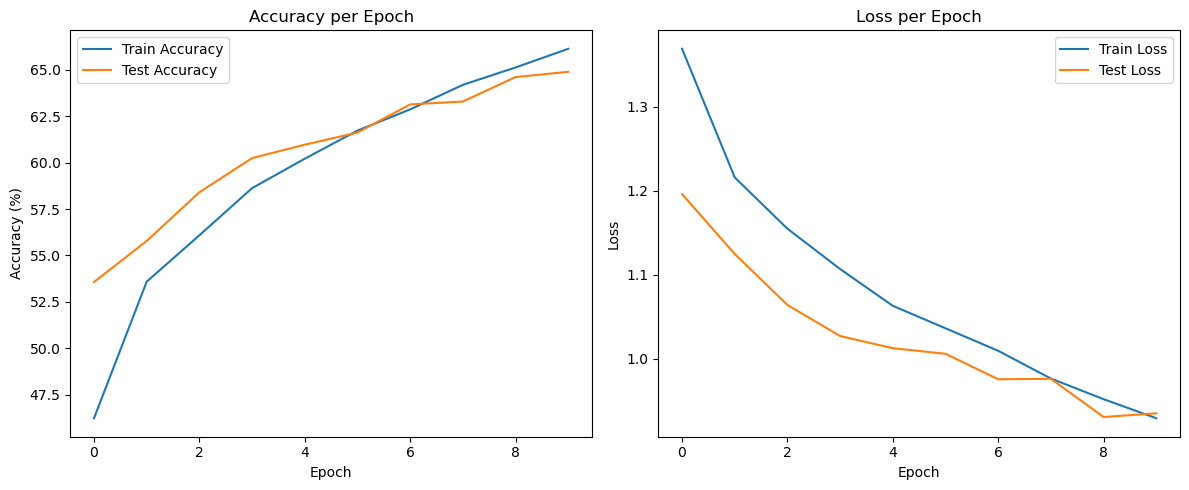

In [9]:
# Evaluate and plot results for RAF-DB model
print("\nEvaluation on RAF-DB:")
evaluate_model(raf_model, raf_test_loader, raf_classes)
plot_training_curves(raf_train_acc, raf_test_acc, raf_train_loss, raf_test_loss)

# Evaluate and plot results for FER-2013 model
print("\nEvaluation on FER-2013:")
evaluate_model(fer_model, fer_test_loader, fer_classes)
plot_training_curves(fer_train_acc, fer_test_acc, fer_train_loss, fer_test_loss)



Prediction using RAF-DB model:


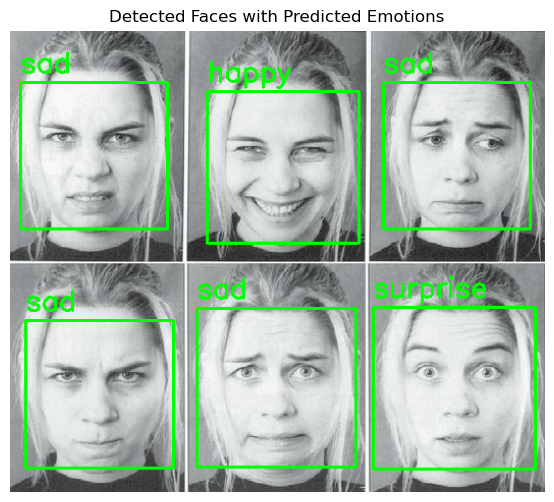


Prediction using FER-2013 model:


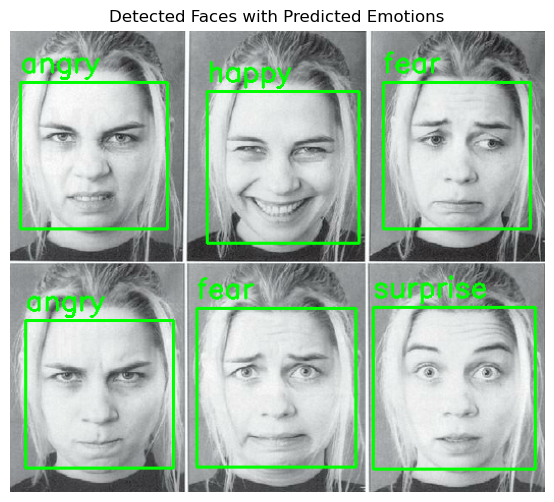

In [10]:
# Make predictions on an image using RAF-DB model
print("\nPrediction using RAF-DB model:")
predict_faces_in_image("test.png", raf_model, raf_transform, raf_classes)

# Make predictions on an image using FER-2013 model
print("\nPrediction using FER-2013 model:")
predict_faces_in_image("test.png", fer_model, fer_transform, fer_classes)
